In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
# from keras.models import Model, load_model
# from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
# from keras.preprocessing.image import ImageDataGenerator
# np.random.seed(22)

In [3]:
# Do not forget to include the last slash
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['MCI']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
norm_images, norm_labels = load_normal('./datasett/training/MCI/')

100%|██████████████████████████████████████████████████████████████████████████████| 5517/5517 [01:40<00:00, 55.05it/s]


In [4]:
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array(["AD"]*len(pneu_files))
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels


In [5]:
pneu_images, pneu_labels = load_pneumonia('./datasett/training/AD/')

100%|██████████████████████████████████████████████████████████████████████████████| 5517/5517 [01:42<00:00, 53.94it/s]


In [6]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [7]:
np.unique(y_train)

array(['AD', 'MCI'], dtype='<U3')

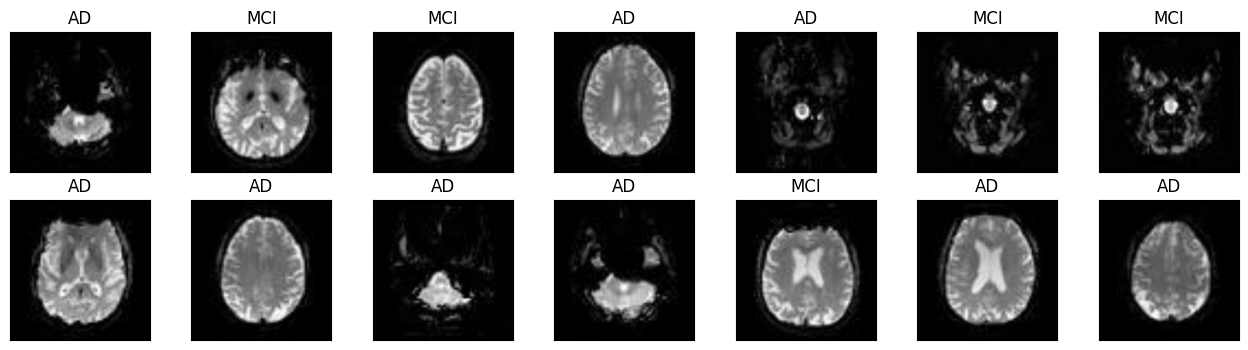

In [8]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [9]:
norm_images_test, norm_labels_test = load_normal("./datasett/test/MCI/")
pneu_images_test, pneu_labels_test = load_pneumonia('./datasett/test/AD/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1411/1411 [00:31<00:00, 44.80it/s]


In [10]:
# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [11]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [12]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [13]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

C:\Users\ASHWANI KAUSHIK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# Reshaping X data into (None, 200, 200, 1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.Xlayers import Dense, Input, Conv2D, MaxPool2D, Flatten

datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [17]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [18]:
# CNN (Convolutional Neural Network)

input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(2, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)


In [19]:
input1

<KerasTensor: shape=(None, 200, 200, 1) dtype=float32 (created by layer 'input_1')>

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                             

In [21]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [22]:
#fit the modelg

history = model.fit(train_gen, epochs=50, 
          validation_data=(X_test, y_test_one_hot))

Epoch 1/50
345/345 [==============================] - 912s 3s/step - loss: 0.7785 - acc: 0.9099 - val_loss: 4.6848 - val_acc: 0.4603
Epoch 2/50
345/345 [==============================] - 917s 3s/step - loss: 0.0518 - acc: 0.9825 - val_loss: 6.1258 - val_acc: 0.5305
Epoch 3/50
345/345 [==============================] - 902s 3s/step - loss: 0.0368 - acc: 0.9885 - val_loss: 4.8681 - val_acc: 0.5606
Epoch 4/50
345/345 [==============================] - 892s 3s/step - loss: 0.0178 - acc: 0.9943 - val_loss: 6.8855 - val_acc: 0.5556
Epoch 5/50
345/345 [==============================] - 889s 3s/step - loss: 0.0225 - acc: 0.9915 - val_loss: 5.6141 - val_acc: 0.5578
Epoch 6/50
345/345 [==============================] - 895s 3s/step - loss: 0.0134 - acc: 0.9950 - val_loss: 5.2381 - val_acc: 0.5773
Epoch 7/50
345/345 [==============================] - 882s 3s/step - loss: 0.0292 - acc: 0.9908 - val_loss: 4.5382 - val_acc: 0.5673
Epoch 8/50
345/345 [==============================] - 886s 3s/step - 

In [23]:
# Saving model
model.save('pneumonia_cnn.h5')

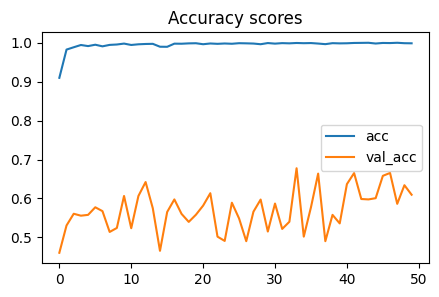

In [24]:
plt.figure(figsize=(5,3))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

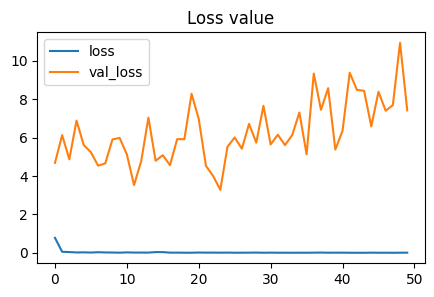

In [25]:
plt.figure(figsize=(5,3))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [26]:
# Predicting test data
predictions = model.predict(X_test)
print(predictions)

89/89 [==============================] - 54s 605ms/step
[[3.2537686e-14 1.0000000e+00]
 [9.7857258e-13 1.0000000e+00]
 [6.9920191e-14 1.0000000e+00]
 ...
 [1.0000000e+00 8.7912009e-16]
 [1.0000000e+00 8.4981028e-15]
 [1.0000000e+00 3.5778243e-20]]


In [27]:
len(predictions)

2822

In [28]:
predictions[0]

array([3.2537686e-14, 1.0000000e+00], dtype=float32)

In [29]:
predictions[2821]

array([1.0000000e+00, 3.5778243e-20], dtype=float32)

In [30]:
predictions = one_hot_encoder.inverse_transform(predictions)
print('Model evaluation')
print(one_hot_encoder.categories_)

Model evaluation
[array(['AD', 'MCI'], dtype='<U3')]


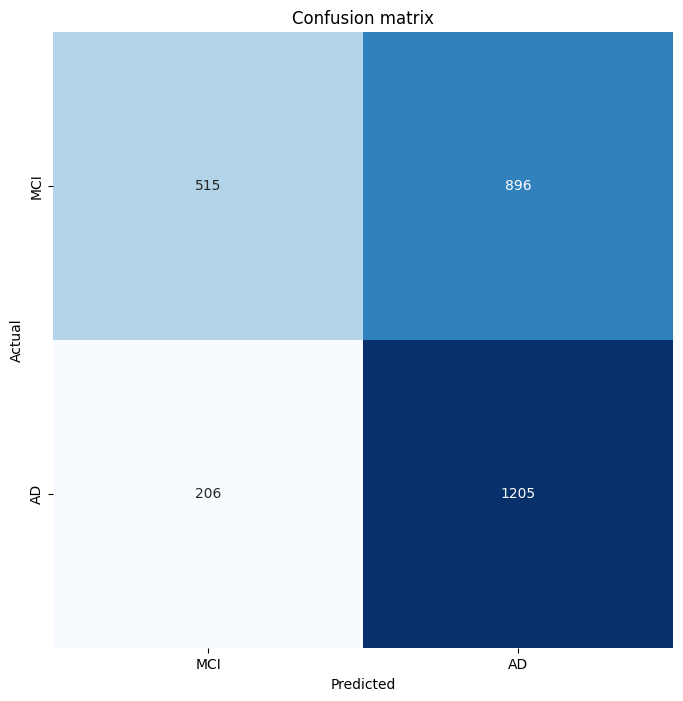

In [31]:
classnames = ['MCI', 'AD']

# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
predictions

array([['MCI'],
       ['MCI'],
       ['MCI'],
       ...,
       ['AD'],
       ['AD'],
       ['AD']], dtype='<U3')